In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt

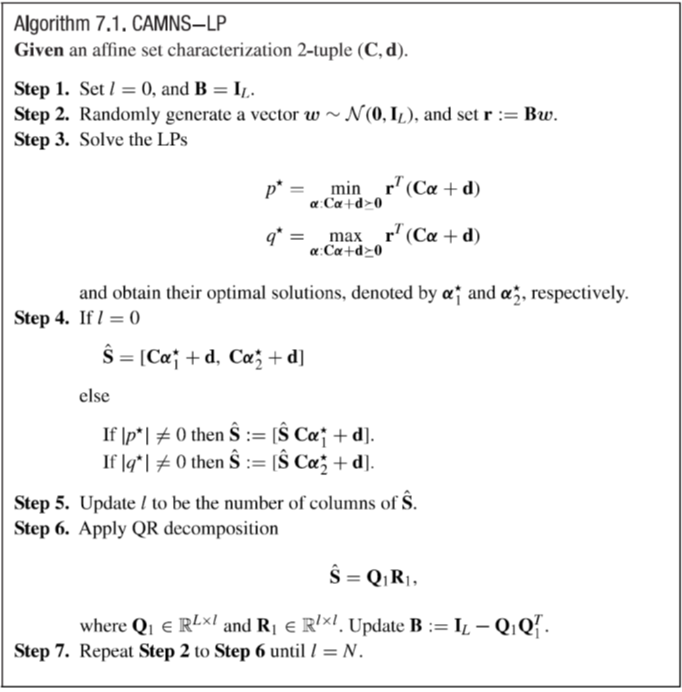

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "AlGoCaMns.png")

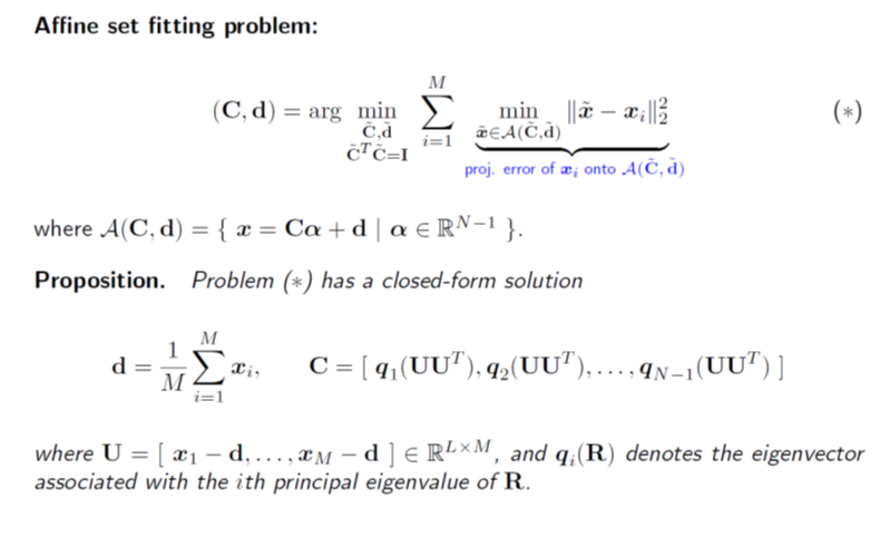

In [3]:
Image(filename = "Affine.png")

In [4]:
from scipy.optimize import LinearConstraint 
from scipy.optimize import minimize

In [5]:
def algo(X, L, N=3):
    def count_C(X, d, N=3):
        U = X - np.tile(d, (1, X.shape[1]))
        C = U[:, :2]
        return C
    
    def LPs_function(x):
        return r.dot(C @ x + d.flatten())
    
    def solve_p_star(C, d, r):
        constraints = LinearConstraint(C,
                                      lb = -d.flatten(),
                                      ub = np.inf)
        
        return minimize(LPs_function,
                        x0=np.zeros(N-1),
                        constraints=constraints,
                        method='COBYLA').x
    
    def solve_q_star(C, d, r):
        constraints = LinearConstraint(C,
                                      lb = -d.flatten(),
                                      ub = np.inf)
        
        return minimize(lambda x: -LPs_function(x),
                        x0=np.zeros(N-1),
                        constraints=constraints,
                        method='COBYLA').x
        
    d = X.mean(axis=1).reshape(-1, 1)
    C = count_C(X, d, N=3)
    #Step 1: set l=0 and B = I_L
    l = 0
    B = np.eye(L)
    
    while l != N:
        #Step 2: generate omega, set r
        omega = sps.norm().rvs(L)
        r = B.dot(omega)
        
        #Step 3: Solve the LPs
        
        a1_star = solve_p_star(C, d, r)
        a2_star = solve_q_star(C, d, r)
        
        p_star = LPs_function(a1_star)
        q_star = LPs_function(a2_star)
        
        #Step 4:
        
        if l == 0:
            S = np.vstack((C.dot(a1_star) + d.T, C.dot(a2_star) + d.T)).T
        else:
            if np.linalg.norm(p_star) != 0:
                column = C.dot(a1_star) + d.T
                S = np.hstack((S, column.reshape(-1, 1)))
            elif np.linalg.norm(q_star) != 0:
                column = C.dot(a2_star) + d.T
                S = np.hstack((S, column.reshape(-1, 1)))
                
        #Step 5
        l = S.shape[1]

        # Step 6

        Q, R = np.linalg.qr(S)
        B = np.eye(L) - Q @ Q.T
        
    return S

Распределим теперь веса так, чтобы основной вклад вносил изначальная картинка, подпишем их

In [6]:
file_names = ['alen.jpg', 'vlad.jpg', 'denis.jpg']
imgs = np.array([plt.imread(name) for name in file_names])
imgs_flat = np.array([img.flatten() for img in imgs])

weights = np.array([
    [0.5, 0.25, 0.1],
    [0.2, 0.5, 0.3],
    [0.3, 0.25, 0.6]
])

mix = imgs_flat.T @ weights

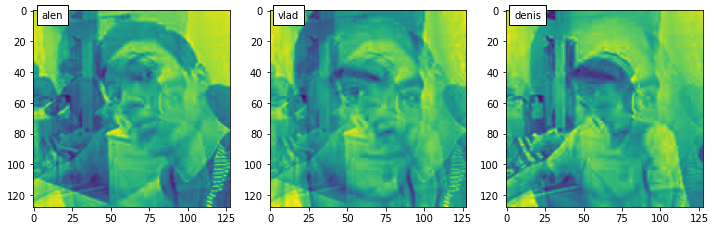

In [7]:
plt.figure(figsize=(12, 8))
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    ax.imshow(mix[:, i].reshape(128, 128), label=file_names[i])
    ax.text(5, 5, file_names[i][:-4], bbox={'facecolor': 'white', 'pad': 5})
plt.show()

Пока что понятно кто где, но все равно изображения достаточно шумные

In [8]:
result = algo(mix, mix.shape[0])

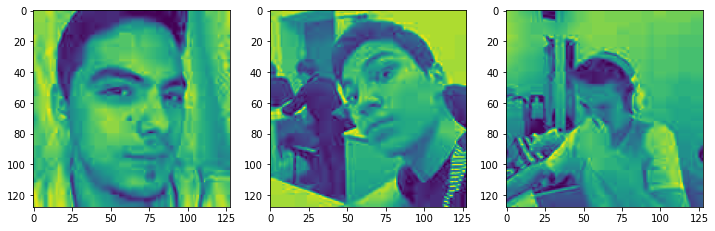

In [9]:
plt.figure(figsize=(12, 8))
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    ax.imshow(result[:, i].reshape(128, 128))
plt.show()

Получилось хорошо восстановить изображения, хотя и в другом порядке.

Посмотрим теперь что произойдет если сделать тоже самое с единичной матрицей

In [10]:
file_names = ['alen.jpg', 'vlad.jpg', 'denis.jpg']
imgs = np.array([plt.imread(name) for name in file_names])
imgs_flat = np.array([img.flatten() for img in imgs])

weights = np.eye(3)

mix = imgs_flat.T @ weights

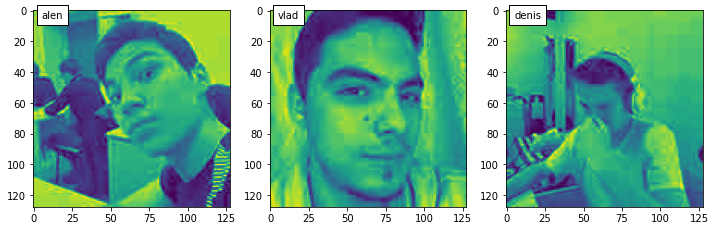

In [11]:
plt.figure(figsize=(12, 8))
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    ax.imshow(mix[:, i].reshape(128, 128), label=file_names[i])
    ax.text(5, 5, file_names[i][:-4], bbox={'facecolor': 'white', 'pad': 5})
plt.show()

In [12]:
result = algo(mix, mix.shape[0])

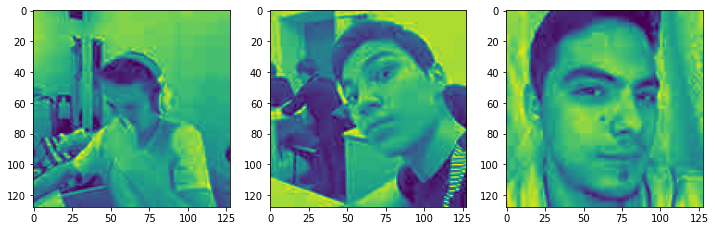

In [13]:
plt.figure(figsize=(12, 8))
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    ax.imshow(result[:, i].reshape(128, 128))
plt.show()

Изображения получились такие же, хотя в другом порядке.

Теперь попробуем подать две одинаковые картинки, в сумме веса должны оказаться больше, чем у третьей

In [22]:
file_names = ['alen.jpg', 'alen.jpg', 'denis.jpg']
imgs = np.array([plt.imread(name) for name in file_names])
imgs_flat = np.array([img.flatten() for img in imgs])

weights = np.array([
    [0.5, 0.25, 0.3],
    [0.2, 0.5, 0.3],
    [0.3, 0.25, 0.4]
])

mix = imgs_flat.T @ weights

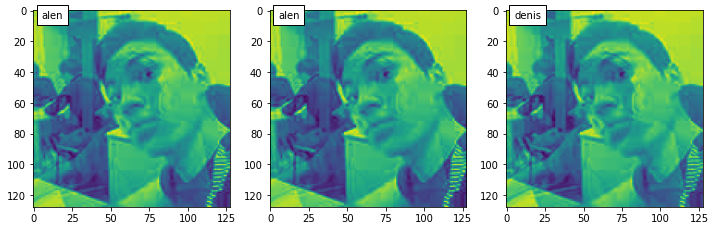

In [23]:
plt.figure(figsize=(12, 8))
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    ax.imshow(mix[:, i].reshape(128, 128), label=file_names[i])
    ax.text(5, 5, file_names[i][:-4], bbox={'facecolor': 'white', 'pad': 5})
plt.show()

Третью картинку теперь вообще плохо видно

In [24]:
result = algo(mix, mix.shape[0])

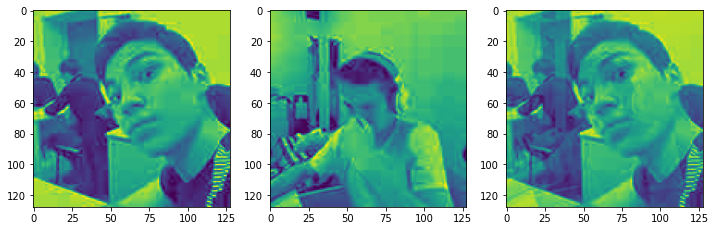

In [25]:
plt.figure(figsize=(12, 8))
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    ax.imshow(result[:, i].reshape(128, 128))
plt.show()

Видно, что несмотря на то, что суммарный вклад картинки оказался такой же, мы смогли ее отличить от двух одинаковых. 

**Вывод** : Имплементировали метод, который показал себя хорошо даже в случае, когда визуальный невозможно отличить третью картинку, что достаточно круто.